<a href="https://colab.research.google.com/github/arijqureshi/Disaster-Tweet-Prediction-Model/blob/main/Multinomial_Naive_Bayes_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Necessary Packages

In [ ]:
import jax.numpy as np
import jax
from jax import grad, jit, vmap
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from collections import defaultdict
import re
import random

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#Creating the Naive Bayes Class

In [40]:
def preprocess_string(str_arg):
    # function to preprocess strings
    # takes in a string
    # removes everything that isn't a letter
    # replaces multiple spaces with single spaces
    # removes links
    # removes emojis
    # returns cleaned_str

    cleaned_str = str_arg
    cleaned_str=re.sub('[^a-z\s]+',' ',cleaned_str,flags=re.IGNORECASE) #every char except alphabets is replaced
    cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
    cleaned_str = re.sub(r'https?://\S+', '', cleaned_str) # remove links
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    cleaned_str = emoji_pattern.sub(r'',cleaned_str) # remove emojis
    cleaned_str=cleaned_str.lower() #converting the cleaned string to lower case

    return cleaned_str # returning the preprocessed string

def syn(word): # a function to find synonyms of words
  synonyms = []
  for syn in wordnet.synsets(word):
    for lm in syn.lemmas():
      synonyms.append(lm.name()) #adding into synonyms
  if len(synonyms) != 0:
    return synonyms[0] #return first synonym if it exists
  else:
    return word # else return word

class NaiveBayes:
    
    def __init__(self,unique_classes, lsc, num_syn):
        
        self.classes=unique_classes # Constructor is sinply passed with unique number of classes of the training set
        self.lsc = lsc
        self.num_syn = num_syn

    def addToBow(self,input,dict_index):
        # a function to add each word to a dictionary for its corresponding class

        if isinstance(input,numpy.ndarray): input=input[0] # to generalize for different formats of input
        
        noSyn = True
        if self.num_syn != 0:
          randnums = [random.randrange(len(input.split())) for _ in range(self.num_syn)]
          noSyn = False
        
        i = 0
        for token_word in input.split(): #for every word in preprocessed example
            if not noSyn and i in randnums:
              token_word = syn(token_word)
            self.bow_dicts[dict_index][token_word]+=1 #increment in its count, will automatically add to dict if not already there
            i += 1

    def fit(self,dataset,labels):
        
        # the main function to train the MNNB model - computes a bag of words for each category/class

    
        self.examples=dataset
        self.labels=labels
        self.bow_dicts=numpy.array([defaultdict(lambda: 0) for index in range(self.classes.shape[0])])
        
        if not isinstance(self.examples,np.ndarray): self.examples=numpy.array(self.examples) # convert to numpy array if not already passed as one
        if not isinstance(self.labels,np.ndarray): self.labels=numpy.array(self.labels)
            
        #constructing BoW for each category
        for cat_ind, cat in enumerate(self.classes):
          
            all_cat_examples=self.examples[self.labels==cat] #filter all examples where target == cat
            
            # preprocess all examples
            
            cleaned_examples=[preprocess_string(cat_example) for cat_example in all_cat_examples]
            
            cleaned_examples=pd.DataFrame(data=cleaned_examples)
            
            #now costruct BoW of this particular category
            numpy.apply_along_axis(self.addToBow,1,cleaned_examples,cat_ind)

            # finished training model        
      
        
      
        # to speed up computation and not needlessly recalculate the same numbers over and over, we calculate
        # prior probabilities of each class, our total vocabulary, and the denominator value for each class
        # denom =  [ count(c) + |V| + 1 ] will be used at testing
        # because testing formula: [ count(w|c) + lsc ] / [ count(c) + |V| + lsc ] } * p(c)

        prob_classes=np.empty(self.classes.shape[0])
        all_words=[]
        cat_word_counts=np.empty(self.classes.shape[0])
        for cat_ind,cat in enumerate(self.classes):
           
            #Calculating prior probability p(c) for each class
            prob_classes = prob_classes.at[cat_ind].set(np.sum(self.labels==cat)/float(self.labels.shape[0]))
            # prob_classes[cat_index]=np.sum(self.labels==cat)/float(self.labels.shape[0]) 
            
            #Calculating total counts of all the words of each class 
            count=list(self.bow_dicts[cat_ind].values())
            cat_word_counts = cat_word_counts.at[cat_ind].set(np.sum(np.array(list(self.bow_dicts[cat_ind].values())))+1)
            # cat_word_counts[cat_index]=np.sum(np.array(list(self.bow_dicts[cat_index].values())))+1 # |v| is remaining to be added
            
            #get all words of this category                                
            all_words+=self.bow_dicts[cat_ind].keys()
                                                     
        
        #combine all unique words of every category to get vocabulary V of entire training set
        
        self.vocab=numpy.unique(numpy.array(all_words))
        self.vocab_length=self.vocab.shape[0]
                                  
        #computing denominator value for each class                                     
        denoms=np.array([cat_word_counts[cat_index]+self.vocab_length+self.lsc for cat_index,cat in enumerate(self.classes)])                                                                          
      

        # saving all information for each category in each element of cats_info for organization purposes
        # each element of cats_info has a tuple that stores the dictionary at index 0, prior probability at index 1,
        # and denom value at index 2
        self.cats_info=[(self.bow_dicts[cat_index],prob_classes[cat_index],denoms[cat_index]) for cat_index,cat in enumerate(self.classes)]                               
        self.cats_info=numpy.array(self.cats_info)                                 
                                              
                                              
    def getExampleProb(self,test_example):                                
                                            
        # a function to get posterior probability for each class for given test_example
                                        
        likelihood_prob=np.zeros(self.classes.shape[0]) #to store probability w.r.t each class
        #finding probability w.r.t each class of the given test example
        for cat_ind,cat in enumerate(self.classes): 

            for test_token in test_example.split(): #split the test example and get p of each test word
                                
                # for each word w computes [ count(w|c)+lsc ] / [ count(c) + |V| + lsc ]                               
                                              
                #get total count of this test token from it's respective training dict to get numerator value                           
                test_token_counts=self.cats_info[cat_ind][0].get(test_token,0)+self.lsc
                
                #now get likelihood of this test_token word by dividing by the denominator value we found earlier                          
                test_token_prob=test_token_counts/float(self.cats_info[cat_ind][2])                              
                

                # take logs to prevent underflow
                # we are able to just sum the logs since 
                # log(AB) = log(A) + log(B)
                likelihood_prob = likelihood_prob.at[cat_ind].add(np.log(test_token_prob))
                # likelihood_prob[cat_index]+=np.log(test_token_prob)
                                              
        # we have likelihood estimate of the given example against every class but we need posterior probility
        post_prob=np.empty(self.classes.shape[0])
        for cat_ind,cat in enumerate(self.classes):
            # add likelihood estimate to prior probability to get posterior probability for each class
            sum = likelihood_prob.at[cat_ind].get() + np.log(self.cats_info[cat_ind][1])
            post_prob = post_prob.at[cat_ind].set(sum)
            #post_prob[cat_index]=likelihood_prob[cat_index]+np.log(self.cats_info[cat_index][1])                                  
      
        return post_prob
    
   
    def predict(self,test_set):    
        # function to predict class values for array of given input
        # returns predictions of the class values for each example in input

        predictions=[] #to store prediction of each test example
        for input in test_set: 
                                              
            #preprocess the test example using the same function used for training set examples                                  
            cleaned_input=preprocess_string(input) 

            #get prob of this example for both classes                          
            posterior_prob=self.getExampleProb(cleaned_input) 
            
            #pick the max value and store that in predictions array
            predictions.append(self.classes[np.argmax(posterior_prob)])
                
        return np.array(predictions)


#Importing Data

In [ ]:
!kaggle -v

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
mv ./kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle -v

Kaggle API 1.5.12


In [ ]:
%ls /root/.kaggle/

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions files -c nlp-getting-started

name                    size  creationDate         
---------------------  -----  -------------------  
train.csv              965KB  2019-12-16 20:36:20  
test.csv               411KB  2019-12-16 20:36:20  
sample_submission.csv   22KB  2019-12-16 20:36:20  


In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 112MB/s]


In [ ]:
import os, shutil

In [ ]:
if not os.path.exists('/content/disaster-tweets'):
  os.mkdir('/content/disaster-tweets')

In [ ]:
!unzip -q /content/nlp-getting-started.zip -d /content/disaster-tweets

In [ ]:
train_tweets = pd.read_csv('/content/disaster-tweets/train.csv')
test_tweets = pd.read_csv('/content/disaster-tweets/test.csv')

#Testing Hyperparamter Value Changes

In [33]:
X = train_tweets['text'].values
y = train_tweets['target'].values
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=.2, random_state=2020)
lsc_vals = np.zeros(10)
test_accs = np.zeros(10)
for i in range(0, 11):
  lsc = float(i)/10
  lsc_vals = lsc_vals.at[i].set(lsc)
  nb = NaiveBayes(np.unique(y), lsc, 0) 
  nb.fit(X_train, y_train) # training the model
  predClasses = nb.predict(X_test)
  test_acc = np.sum(predClasses == y_test)/float(len(y_test))
  test_accs = test_accs.at[i].set(test_acc)
  print(lsc, test_acc)


1.0 0.79645437
1.1 0.79317135
1.2 0.79317135
1.3 0.7925148
1.4 0.7925148
1.5 0.7925148
1.6 0.79317135


KeyboardInterrupt: ignored

Text(0, 0.5, 'Model Test Accuracy')

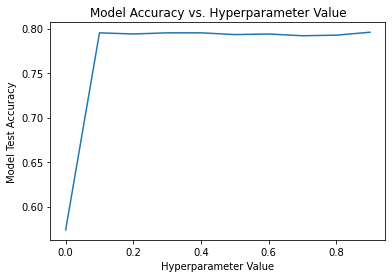

In [ ]:
plt.plot(lsc_vals, test_accs)
plt.title("Model Accuracy vs. Hyperparameter Value")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Model Test Accuracy")

#Testing Synonym Changes

In [ ]:
syn_nums = np.zeros(9)
test_accs = np.zeros(9)
for i in range(1, 9):
  syn_nums = syn_nums.at[i].set(i)
  nb = NaiveBayes(np.unique(y), 1, i) 
  nb.fit(X_train, y_train) # training the model
  predClasses = nb.predict(X_test)
  test_acc = np.sum(predClasses == y_test)/float(len(y_test))
  test_accs = test_accs.at[i].set(test_acc)
  print(i, test_acc)

In [ ]:
plt.plot(syn_nums, test_accs)
plt.title("Model Accuracy vs. Number of Synonyms Per Tweet")
plt.xlabel("Number of Synonyms")
plt.ylabel("Model Test Accuracy")

#Testing Dataset Size

In [ ]:
len_data = np.zeros(9)
test_accs = np.zeros(9)
for i in range(1, 9):
  split_size = float(i)/10 # calculating dataset split size (.1 means 10% for test)
  X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=split_size, random_state=2020)
  len_data = len_data.at[i].set(len(X_train))
  nb = NaiveBayes(np.unique(y), 1, i) 

  nb.fit(X_train, y_train) # training the model
  predClasses = nb.predict(X_test)

  test_acc = np.sum(predClasses == y_test)/float(len(y_test)) # calculate test accuracy
  test_accs = test_accs.at[i].set(test_acc)
  print(len(X_train), test_acc)

In [ ]:
plt.plot(len_data, test_accs)
plt.title("Model Accuracy vs. Train Dataset Size")
plt.xlabel("Train Dataset Size")
plt.ylabel("Model Test Accuracy")

#Optimal Run of Model

In [41]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=.2, random_state=2020)
nb = NaiveBayes(np.unique(y), 1, 5) 
nb.fit(X_train, y_train) # training the model
predClasses = nb.predict(X_test)
test_acc = np.sum(predClasses == y_test)/float(len(y_test))
print("Final Test Accuracy:", test_acc)

Final Test Accuracy: 0.79448456
